<a href="https://colab.research.google.com/github/SamuelBFG/ga-fading/blob/main/DEAP_KappaMu_Fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genetic Algorithms: $\kappa$-$\mu$ fading distribution parameter estimation using deap.


In [1]:
# !pip install deap

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy import special as sp
import deap
from deap import algorithms, base, creator, tools
from KappaMu import KappaMu

import seaborn as sns
sns.set(style='whitegrid')
sns.set_context('notebook')

def evaluation(theta):
  X = np.array([1,2,3,4,5,20,26,7])
  Y = np.array([5,7,9,11,13,43,55,17])

  n = len(X)
  y_pred = theta[0]*X + theta[1]
  cost = 1/n * sum(val**2 for val in (Y-y_pred))
  return (cost,)

def computePDF(r, kappa, mu, r_hat):
  A = (2*mu * ((1 + kappa)**((mu+1)/2))) \
          /((kappa**((mu - 1)/2)) * np.exp(mu * kappa))
  R = r / r_hat
  B = (R**mu) * np.exp(- mu*(1 + kappa)*(R**2))
  C = sp.iv(mu - 1, 2*mu * R * np.sqrt(kappa*(1 + kappa)))
  PDF = A * B * C / r_hat 
  return PDF

def fitnessFunction(theta):
  # X = np.array([1,2,3,4,5,20,26,7])
  # Y = np.array([5,7,9,11,13,43,55,17])
  X = ku.X
  Y = ku.Y
  n = len(X)
  kappa = theta[0]
  mu = theta[1]
  r_hat = theta[2]

  y_pred = computePDF(X, kappa, mu, r_hat)
  # print('y_pred', y_pred)
  # y_pred = theta[0]*X + theta[1]
  cost = 1/n * sum(val**2 for val in (Y-y_pred))
  return (cost,)

In [3]:
ku = KappaMu(kappa=1, mu=4, r_hat=1, numSamples=100, numSim=10**6)

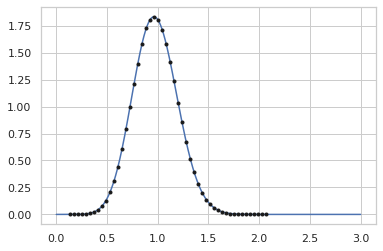

In [4]:
r = np.linspace(0, 3, 3000) # theoretical envelope PDF x axes
plt.plot(r, ku._pdf(r))
plt.plot(ku.X[1:len(ku.X):2], ku.Y[1:len(ku.Y):2], "k.", label='Simulation')

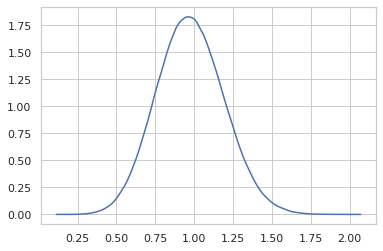

In [5]:
plt.plot(ku.X,ku.Y)

In [6]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) #-1 to minimze, +1 to maximize
creator.create("Individual", list, fitness=creator.FitnessMin)

# toolbox = base.Toolbox()

### One individual for each $\hat{\theta}_i$


In [7]:
toolbox = base.Toolbox()

In [8]:
toolbox.register("attr_bool", np.random.uniform, 0.1, 5)
toolbox.attr_bool()

toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, 3)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.individual()

[2.7490608733683124, 2.1093823017188433, 3.1241665254892133]

In [9]:
toolbox.register("evaluate", fitnessFunction)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

In [10]:
pop = toolbox.population(n=500)

In [11]:
hof = tools.ParetoFront()

In [12]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [13]:
# sortedPop = sorted(pop, key=lambda ind:ind.fitness)

In [14]:
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.3,\
                               ngen=10, stats=stats, halloffame=hof, verbose=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply


gen	nevals	avg	std	min	max
0  	500   	nan	nan	nan	nan
1  	317   	nan	nan	nan	nan
2  	321   	nan	nan	nan	nan
3  	327   	nan	nan	nan	nan
4  	341   	0.13074	0.227292	0.000166696	1.92937
5  	322   	0.0764064	0.188475	0.000122512	2.22611
6  	320   	0.0798482	0.189109	0.000122512	0.694323
7  	321   	0.0621811	0.171479	0.000122512	0.693309
8  	324   	0.0754699	0.190553	0.000121158	0.785272
9  	337   	0.0575591	0.1721  	0.000121158	0.707986
10 	302   	0.058946 	0.17544 	0.000121158	0.760141


In [15]:
print('Current best fitness:', fitnessFunction(tools.selBest(pop, k=1)[0]))

Current best fitness: (0.00012115828862295748,)


In [16]:
hof[0]

[2.657321942821025, 2.522792484313327, 0.9938648674325408]

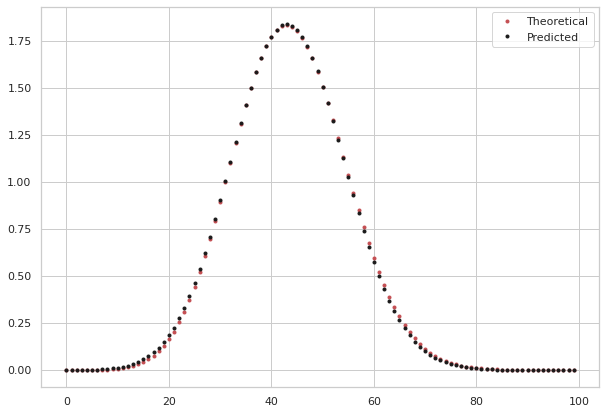

In [17]:
theta = [1,4,1]
kappa = theta[0]
mu = theta[1]
r_hat = theta[2]
X = ku.X
Y = ku.Y
y_pred = computePDF(X, kappa, mu, r_hat)

plt.figure(figsize=(10,7))
plt.plot(y_pred,'.r', label='Theoretical')
plt.plot(computePDF(X,hof[0][0],hof[0][1],hof[0][2]),'.k', label='Predicted')
plt.legend()
plt.show()

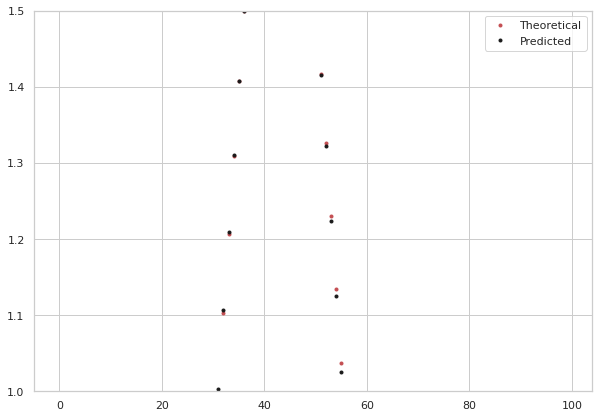

In [18]:
plt.figure(figsize=(10,7))
plt.plot(y_pred,'.r', label='Theoretical')
plt.plot(computePDF(ku.X,hof[0][0],hof[0][1],hof[0][2]),'.k', label='Predicted')
plt.ylim((1,1.5))
plt.legend()
plt.show()

In [19]:
len(hof)

3

In [20]:
print(r'$\theta_0$ is {}, $\theta_1$ is {} and $\theta_1$ is {}.'.format(hof.items[0][0], hof.items[0][1], hof.items[0][2]))

$\theta_0$ is 2.657321942821025, $\theta_1$ is 2.522792484313327 and $\theta_1$ is 0.9938648674325408.


In [21]:
record = stats.compile(pop)
logbook = tools.Logbook()
logbook.record(gen=0, evals=30, **record)

In [22]:
gen = log.select("gen")
fit_mins = log.select("min")
size_avgs = log.select("avg")

In [23]:
# gen, avg = logbook.select("gen", "avg")

In [24]:
# logbook.header = "gen", "avg", "spam"

In [25]:
# print(logbook)

In [26]:
# gen = logbook.select("gen")
# fit_mins = logbook.chapters["fitness"].select("min")
# size_avgs = logbook.chapters["size"].select("avg")

# import matplotlib.pyplot as plt

# fig, ax1 = plt.subplots()
# line1 = ax1.plot(gen, fit_mins, "b-", label="Minimum Fitness")
# ax1.set_xlabel("Generation")
# ax1.set_ylabel("Fitness", color="b")
# for tl in ax1.get_yticklabels():
#     tl.set_color("b")

# ax2 = ax1.twinx()
# line2 = ax2.plot(gen, size_avgs, "r-", label="Average Size")
# ax2.set_ylabel("Size", color="r")
# for tl in ax2.get_yticklabels():
#     tl.set_color("r")

# lns = line1 + line2
# labs = [l.get_label() for l in lns]
# ax1.legend(lns, labs, loc="center right")

# plt.show()

In [27]:
# gen = logbook.select("gen")
# fit_mins = logbook.select("min")
# size_avgs = logbook.select("avg")


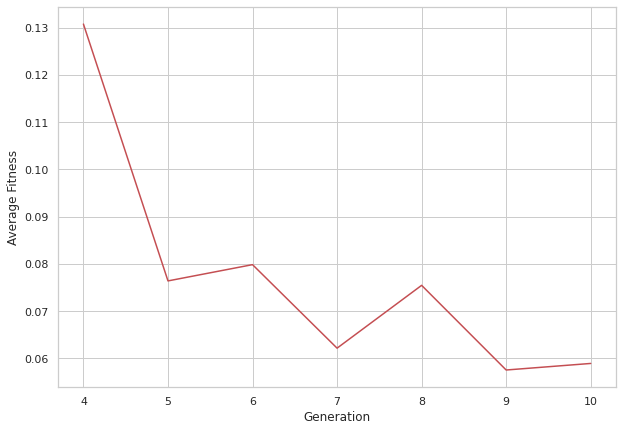

In [28]:
plt.figure(figsize=(10,7))
plt.plot(gen, size_avgs, "r-", label="Average Fitness")
plt.xlabel('Generation')
plt.ylabel('Average Fitness')
plt.show()

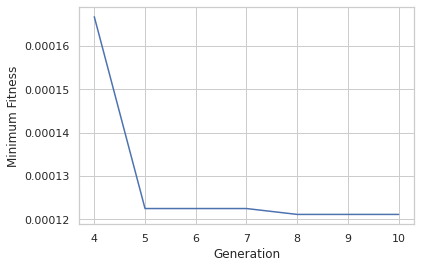

In [29]:
plt.plot(gen, fit_mins, "b-", label="Minimum Fitness")
plt.xlabel('Generation')
plt.ylabel('Minimum Fitness')
plt.show()

In [30]:
data = pd.read_csv('/content/pathAB_SSF_dB_AP8_downsampled1Khz_win50.txt')

In [31]:
data.describe()

,0
count,9280.000000
mean,-0.808481
std,3.949086
min,-23.097000
25%,-2.731100
50%,-0.187945
75%,1.754750
max,8.691000


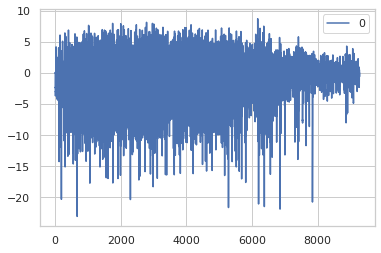

In [32]:
data.plot()

In [33]:
data = np.sqrt(data)
data.describe()

,0
count,4403.000000
mean,1.376164
std,0.580073
min,0.000000
25%,0.948559
50%,1.367297
75%,1.813574
max,2.948050


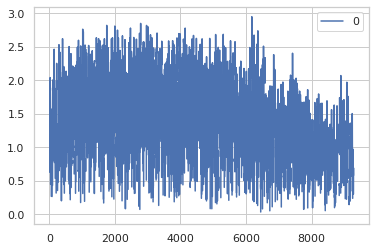

In [34]:
data.plot()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


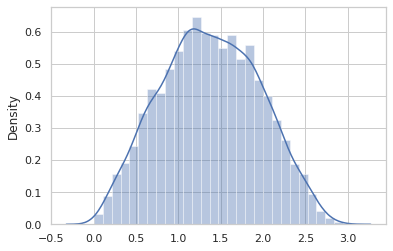

In [35]:
sns.distplot(data)

In [36]:
data.dropna(inplace=True)

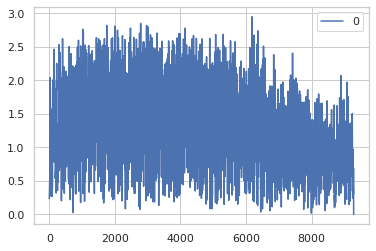

In [37]:
data.plot()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


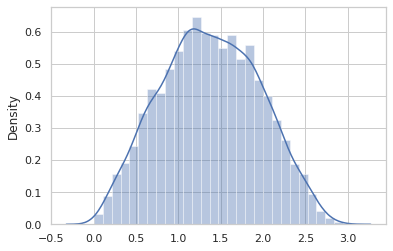

In [38]:
sns.distplot(data)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


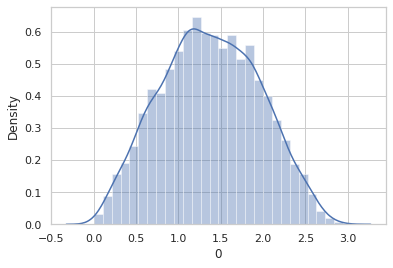

In [39]:
data2 = data.copy()
data = []
for idx, var in enumerate(list(data2)):
    myPlot = sns.distplot(data2[var])
    
    # Fine Line2D objects
    lines2D = [obj for obj in myPlot.findobj() if str(type(obj)) == "<class 'matplotlib.lines.Line2D'>"]
    
    # Retrieving x, y data
    x, y = lines2D[idx].get_data()[0], lines2D[idx].get_data()[1]
    
    # Store as dataframe 
    data.append(pd.DataFrame({'x':x, 'y':y}))

In [40]:
data3 = data[0]['x'][data[0]['x'] > 0]

In [41]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) #-1 to minimze, +1 to maximize
creator.create("Individual", list, fitness=creator.FitnessMin)

# toolbox = base.Toolbox()

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


### One individual for each $\hat{\theta}_i$


In [42]:
toolbox2 = base.Toolbox()

In [43]:
toolbox2.register("attr_bool", np.random.uniform, 0.1, 5)
toolbox2.attr_bool()

toolbox2.register("individual", tools.initRepeat, creator.Individual, toolbox2.attr_bool, 3)
toolbox2.register("population", tools.initRepeat, list, toolbox2.individual)
toolbox2.individual()

[1.7615378340395251, 2.003956535745274, 0.3003217118058603]

In [44]:
toolbox2.register("evaluate", fitnessFunction)
toolbox2.register("mate", tools.cxTwoPoint)
toolbox2.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox2.register("select", tools.selTournament, tournsize=3)

In [45]:
pop2 = toolbox2.population(n=500)

In [46]:
hof2 = tools.ParetoFront()

In [47]:
stats2 = tools.Statistics(lambda ind: ind.fitness.values)
stats2.register("avg", np.mean)
stats2.register("std", np.std)
stats2.register("min", np.min)
stats2.register("max", np.max)

In [48]:
def fitnessFunction(theta):
  # X = np.array([1,2,3,4,5,20,26,7])
  # Y = np.array([5,7,9,11,13,43,55,17])
  X = data3[0]['x']
  Y = data3[0]['y']
  n = len(X)
  kappa = theta[0]
  mu = theta[1]
  r_hat = theta[2]

  y_pred = computePDF(X, kappa, mu, r_hat)
  # print('y_pred', y_pred)
  # y_pred = theta[0]*X + theta[1]
  cost = 1/n * sum(val**2 for val in (Y-y_pred))
  return (cost,)

In [49]:
pop, log = algorithms.eaSimple(pop2, toolbox2, cxpb=0.5, mutpb=0.2,\
                               ngen=100, stats=stats2, halloffame=hof2, verbose=True)

gen	nevals	avg    	std    	min       	max    
0  	500   	0.78234	0.76559	0.00661485	7.10716
1  	270   	0.442582	0.218164	0.0058325 	1.22512
2  	307   	0.276353	0.325522	0.000329643	4.9266 
3  	285   	0.12635 	0.18449 	0.000329643	2.88554
4  	305   	0.0527751	0.0882419	0.000329643	0.653526
5  	307   	0.038092 	0.107189 	0.000255341	1.39373 
6  	318   	0.0325195	0.16519  	6.47116e-05	3.31873 
7  	290   	0.0150715	0.051362 	0.000143644	0.599954
8  	310   	0.0221893	0.0904135	0.000116957	0.810831
9  	277   	0.0194805	0.120304 	6.53595e-05	2.02908 
10 	312   	0.0146261	0.0632222	6.53595e-05	0.623376
11 	277   	0.0154267	0.105811 	2.24294e-05	1.87399 
12 	311   	0.0228913	0.151619 	2.24294e-05	2.09721 
13 	317   	0.0119103	0.0582971	2.24294e-05	0.63145 
14 	289   	0.00805215	0.0479407	2.24294e-05	0.65958 
15 	295   	0.0184086 	0.131522 	2.24294e-05	1.93503 
16 	299   	0.0288874 	0.199301 	2.24294e-05	2.0949  
17 	308   	0.00699025	0.0521127	2.24294e-05	0.58948 
18 	312   	0.0120272 	0.1123  

In [50]:
print(r'$\theta_0$ is {}, $\theta_1$ is {} and $\theta_1$ is {}.'.format(hof.items[0][0], hof.items[0][1], hof.items[0][2]))

$\theta_0$ is 2.657321942821025, $\theta_1$ is 2.522792484313327 and $\theta_1$ is 0.9938648674325408.
